# Data Loading

In [22]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import UserDefinedFunction, col, mean, log1p
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd

import os

"""
Spark session variables declaration and spark initialization
"""

path = os.getcwd()

conf = SparkConf() \
    .setAppName("PostgreSQL Writing to Formatted Table") \
    .set("spark.jars", path+"/../.."+"/driver/postgresql-42.7.3.jar")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()


"""
Connection details for table from formatted zone read
"""

jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": user, "password": password}


df = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dog_caract_formatted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", driver_class) \
    .load()


df.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------------+---------------+-------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+---------------+--------------------+-----------+--------------+--------+------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|          image_link|max_height_female|max_height_male|max_life_expectancy|max_weight_female|max_weight_male|min_height_female|min_height_male|min_life_expectancy|min_weight_female|min_weight_male|                name|playfulness|protectiveness|shedding|trainability|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------------+---------------+-------------------+-----------------+---------------+-----------------+---------------+---

# Missings Treatment

In [23]:
total_missings, missing_cols = 0, []
for name, dtype in df.dtypes:
    try:
        if dtype == 'string':
            filtered_df = df.filter(col(name) == "n/a")
        elif dtype == 'bigint':
            filtered_df = df.filter(col(name) == 101)
        else:
            continue
        class_count = filtered_df.groupBy(name).count()
        number_of_missings = class_count.first()["count"]
        missing_cols.append(name)
        total_missings += number_of_missings
    except TypeError:
        print(f"No Missing Values found on variable {name}")

No Missing Values found on variable barking
No Missing Values found on variable coat_length
No Missing Values found on variable drooling
No Missing Values found on variable energy
No Missing Values found on variable good_with_children
No Missing Values found on variable good_with_other_dogs
No Missing Values found on variable good_with_strangers
No Missing Values found on variable grooming
No Missing Values found on variable image_link
No Missing Values found on variable name
No Missing Values found on variable playfulness
No Missing Values found on variable protectiveness
No Missing Values found on variable shedding
No Missing Values found on variable trainability


In [24]:
print("Total Number of Rows before missings removal:", df.count())
missings_percentage = (total_missings/df.count())*100
print("Percentage of Missings over whole dataset:",missings_percentage)
for name, data_type in df.dtypes:
    if missings_percentage > 10: # If more than 10% of data contains missings a missing imputation method is used
        
            if name in missing_cols:
                if data_type == 'string':

                    #  Agrupem els diferents valors de la columna
                    grouped_df = df.groupBy(col(name))

                    value_counts = grouped_df.count()

                    # Els ordenem de més comuns a menys
                    sorted_counts = value_counts.orderBy(col('count').desc())

                    # Comprovem si el primer valor és el valor null
                    first_value = sorted_counts.first()[0]
                    if first_value is None: 
                        # Si ho és, agafem el segon valor
                        most_common_value = sorted_counts.limit(2).collect()[1][name] # De les dues primeres files, ens quedem amb la segona
                    else:
                        most_common_value = sorted_counts.first()[name]

                    udf = UserDefinedFunction(lambda x: most_common_value if x=="n/a" else x, data_type)

                    df = df.select(*[udf(column).alias(name) if column == name else column for column in df.columns])
                
                elif data_type == 'int':
                    # Mean Extraction
                    mean_value = df.select(mean(col(name))).first()[0]

                    udf = UserDefinedFunction(lambda x: mean_value if x==101 else x, data_type)

                    df = df.select(*[udf(column).alias(name) if column == name else column for column in df.columns])
        
    else: # If missings do not take more than 10% of data it is deemed safe to remove them
        if data_type == 'string':
            df = df.filter(col(name) != "n/a")

        elif data_type == 'int':
            df = df.filter(col(name) != 101)

print("Total Number of Rows after missings removal:", df.count())

Total Number of Rows before missings removal: 552
Percentage of Missings over whole dataset: 0.0
Total Number of Rows after missings removal: 552


# Correlations Study

In [9]:
vector_col = "corr_features"
numeric_variables = [column for column, dtype in df.dtypes if dtype == "bigint" or dtype == "double"]
assembler = VectorAssembler(inputCols=numeric_variables, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_variables, index=numeric_variables) 
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

AttributeError: 'Styler' object has no attribute 'set_precision'

In [10]:
# As supposed, complementary variables with maximum and minimums are greatly correlated so the average could be used instead of a pair of maximum and minimum
pairs,i = [], 0
for row in corr_matrix:
    j = 0
    for cell in row:
        if cell > 0.8 and (numeric_variables[j],numeric_variables[i]) not in pairs and numeric_variables[j] != numeric_variables[i]:
            if numeric_variables[i].split("_")[2] == numeric_variables[j].split("_")[2] and numeric_variables[i].split("_")[1] == numeric_variables[j].split("_")[1]:
                pairs.append((numeric_variables[i],numeric_variables[j]))
        j += 1
    i += 1
pairs

[('max_height_female', 'min_height_female'),
 ('max_height_male', 'min_height_male'),
 ('max_life_expectancy', 'min_life_expectancy'),
 ('max_weight_female', 'min_weight_female'),
 ('max_weight_male', 'min_weight_male')]

In [11]:
pair = pairs[0]
"avg_"+"_".join(pair[0].split("_")[1:])

'avg_height_female'

In [12]:
for pair in pairs:

    marksColumns = [col(pair[0]), col(pair[1])]
    averageFunc = sum(x for x in marksColumns)/len(marksColumns)

    df = df.withColumn("avg_"+"_".join(pair[0].split("_")[1:]), averageFunc)

    df = df.drop(pair[0])
    df = df.drop(pair[1])

df.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+-----------------+---------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|          image_link|                name|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_female|avg_weight_male|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+-----------------+---------------+
|      1|          1|       0|     0|                 3|                   3|                  0|       0|https://api-ninja...|    American Bu

# Data Distribution Visualization

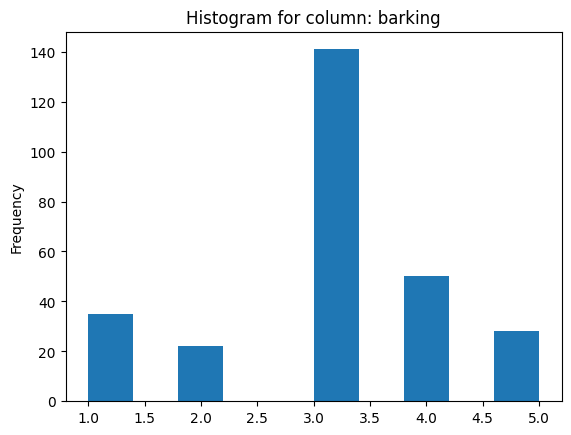

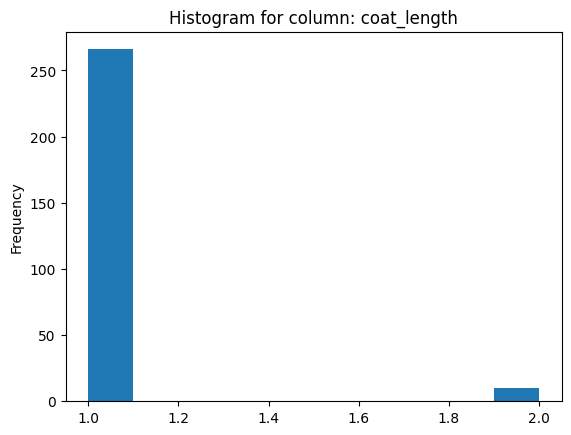

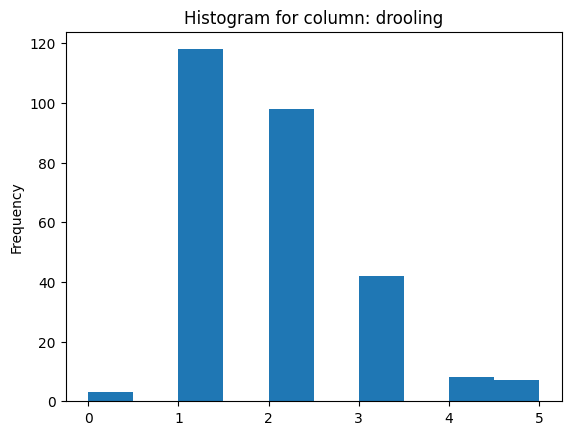

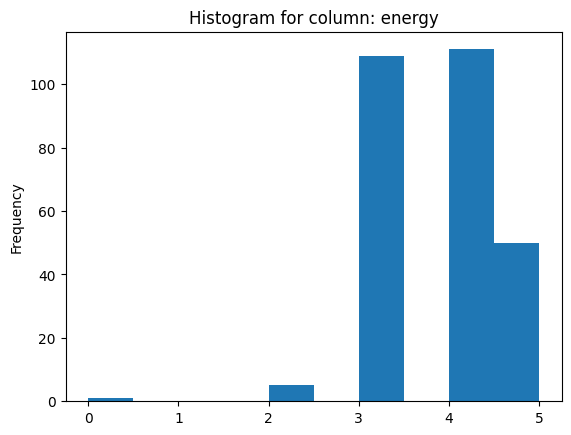

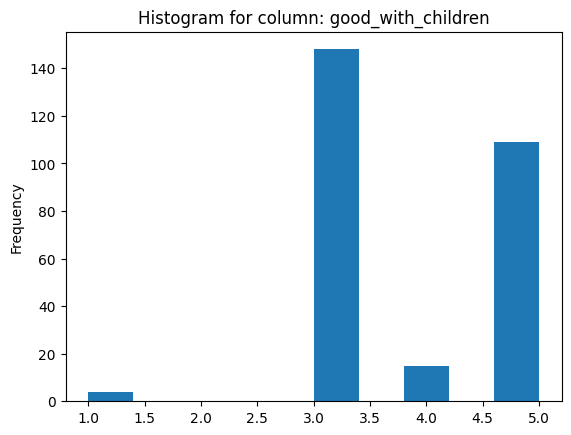

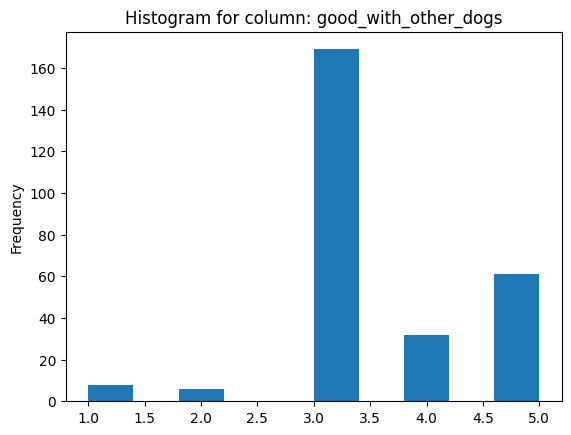

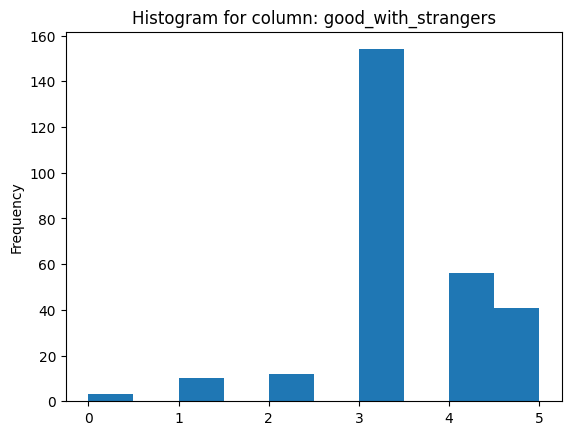

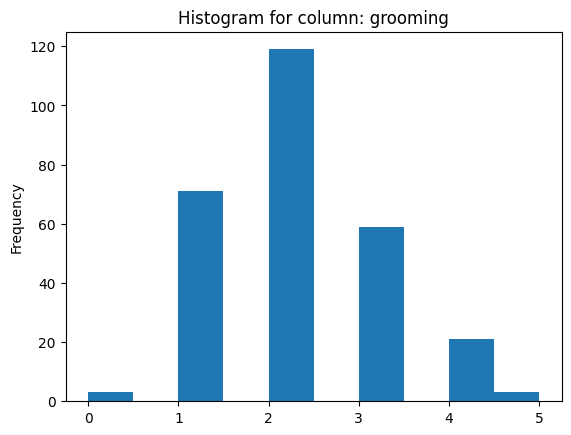

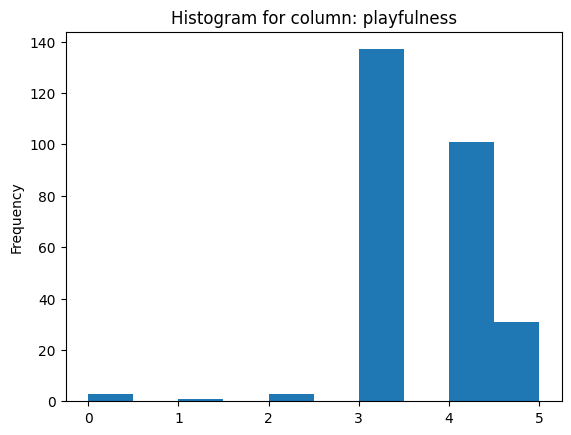

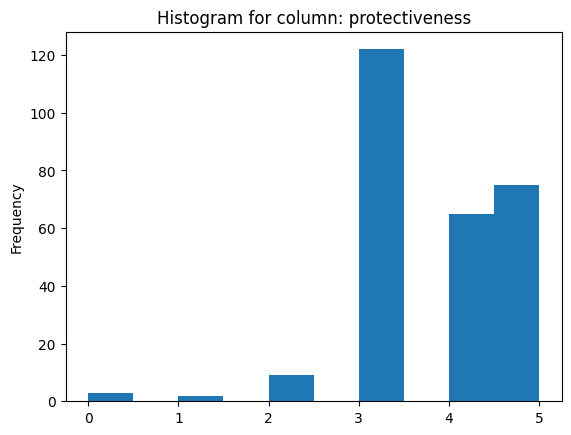

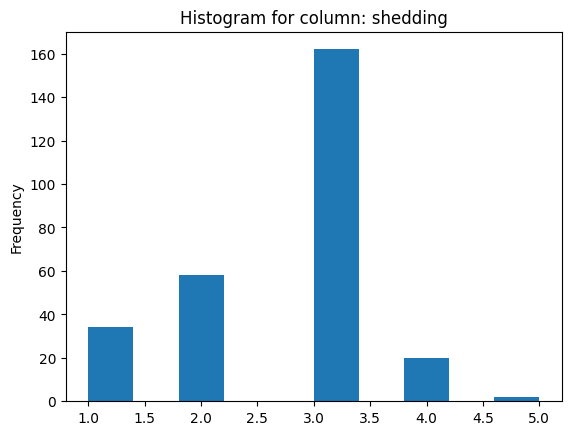

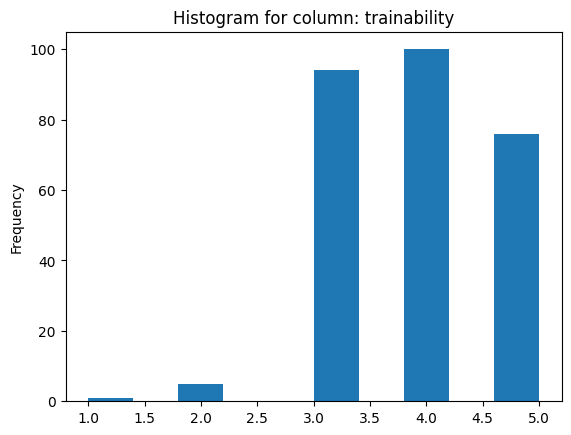

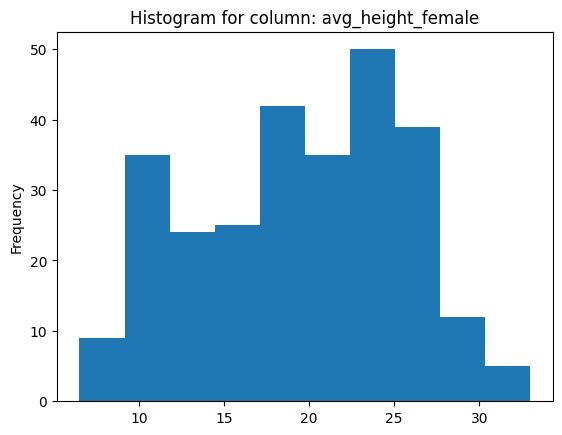

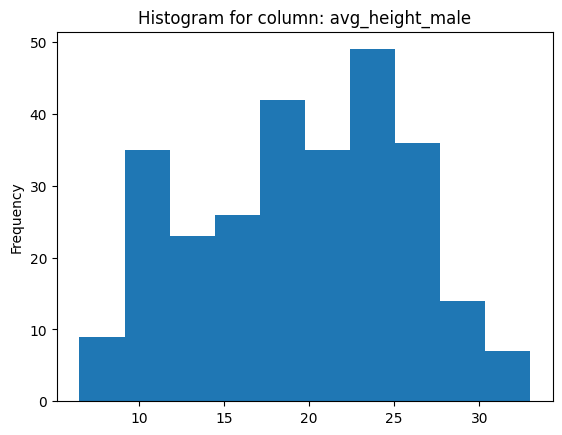

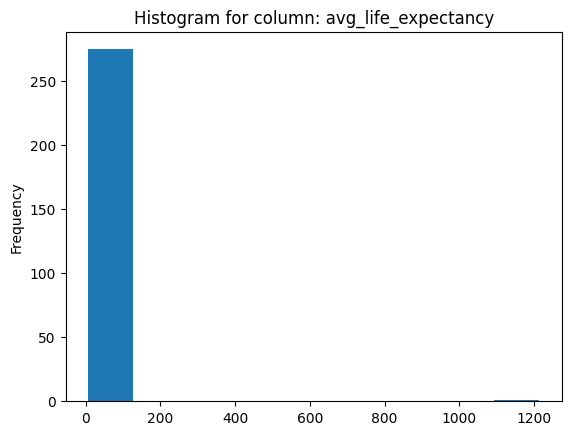

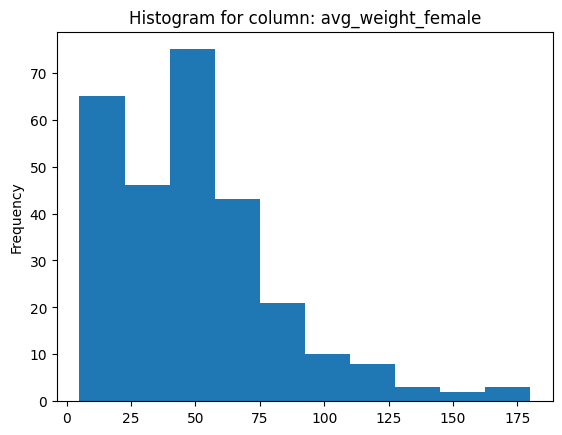

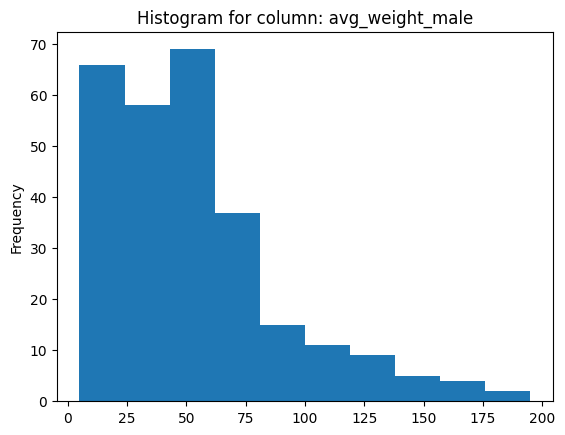

In [13]:
numeric_variables = [column for column, dtype in df.dtypes if dtype == "bigint" or dtype == "double"]
for num_col in numeric_variables:
  df_pandas = df.toPandas()  # Convert to pandas DataFrame
  df_pandas[num_col].plot.hist()
  plt.title(f"Histogram for column: {num_col}")
  plt.show()

We find that distributions with few values are somewhat eskewd to a left or right side whereas other distributions resemble a normal distribution while average weight follows what seems an exponential distribution and could be normalized or some outliers could be removed

In [14]:
cols_to_normalize = ["avg_weight_male","avg_weight_female"]
for col_name in cols_to_normalize:
    # Assuming you have your PySpark DataFrame (`df`) and the column to normalize (`col_to_normalize`)

    normalized_col = log1p(col(col_name))
    df = df.withColumn(col_name + "_log_normalized", normalized_col)
    df = df.drop(col_name)

df.show()


+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|          image_link|                name|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_male_log_normalized|avg_weight_female_log_normalized|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|      1|          1|       0|     0|               

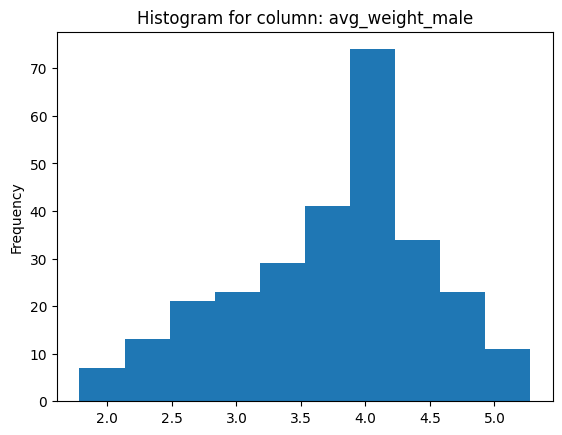

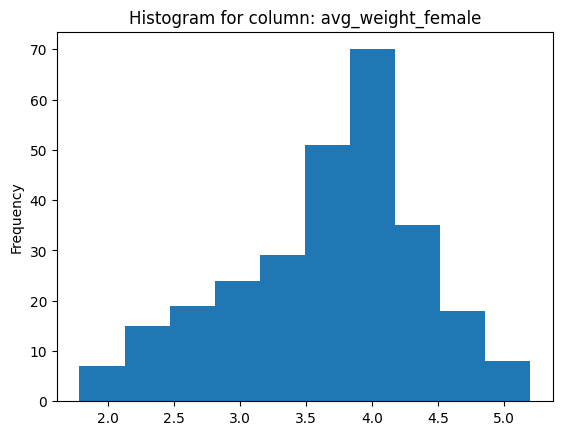

In [15]:
for num_col in cols_to_normalize:
  df_pandas = df.toPandas()  # Convert to pandas DataFrame
  df_pandas[num_col+ "_log_normalized"].plot.hist()
  plt.title(f"Histogram for column: {num_col}")
  plt.show()

By looking at the plots there seem to be outliers but they make sense and removing them from our data may resut in having very little columns. Nonetheless, a method apart from looking at plots should be used.

# Outliers Detection

In [16]:
print("Number of rows prior to outliers removal:",df.count())

df_filtered = df

factor = 1.5
for name, data_type in df.dtypes:

    if data_type == "bigint" or data_type == "double":

        quantiles = df.approxQuantile(name, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        df_filtered = df_filtered.filter((col(name) >= lower_bound) & (col(name) <= upper_bound))

print("Number of rows after outliers removal:",df_filtered.count())
print("Percentage of rows that present outliers:",1-df_filtered.count()/df.count())

Number of rows prior to outliers removal: 276
Number of rows after outliers removal: 207
Percentage of rows that present outliers: 0.25


Almost 30% of data is considered an outlier so imputing it could have great consequences and thus, we will leave the data as it is however, it could be removed and the code to do it is provided below with continue statement so that it may not be executed. Also an imputation by mean could be done just as it is done at the missing imputation code however, we will not get much into details of something that we will not do.

In [12]:
factor = 1.5
for name, data_type in df.dtypes:
    continue

    if data_type == "int":

        quantiles = df.approxQuantile(name, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        df = df.filter((col(name) >= lower_bound) & (col(name) <= upper_bound))

# Variable Renaming

In [17]:
# The variable that needs to be renamed in order for our data to be joined
df = df.withColumnRenamed("name", "Breed")
df = df.drop("image_link")
df.columns

['barking',
 'coat_length',
 'drooling',
 'energy',
 'good_with_children',
 'good_with_other_dogs',
 'good_with_strangers',
 'grooming',
 'Breed',
 'playfulness',
 'protectiveness',
 'shedding',
 'trainability',
 'avg_height_female',
 'avg_height_male',
 'avg_life_expectancy',
 'avg_weight_male_log_normalized',
 'avg_weight_female_log_normalized']

# Data Storage

In [19]:
jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": user, "password": password}


df.write \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver_class) \
  .option("dbtable", "dog_caract_trusted") \
  .option("user", connectionProperties["user"]) \
  .option("password", connectionProperties["password"]) \
  .mode("append") \
  .jdbc(jdbc_url,"dog_caract_trusted")

24/04/25 16:27:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
